In [1]:
import random
from collections import Counter

In [2]:
# Gestures and their payoffs
gestures = {
    "Rock": {"wins": ["Scissors", "Lizard"], "winning_points": 1, "losing_points": -1},
    "Paper": {"wins": ["Rock", "Spock"], "winning_points": 2, "losing_points": -2},
    "Scissors": {"wins": ["Paper", "Lizard"], "winning_points": 3, "losing_points": -3},
    "Lizard": {"wins": ["Spock", "Paper"], "winning_points": 4, "losing_points": -4},
    "Spock": {"wins": ["Scissors", "Rock"], "winning_points": 5, "losing_points": -5}
}

In [3]:
# Counter move for each gesture
counter_moves = {
    "Rock": ["Paper", "Spock"],
    "Paper": ["Scissors", "Lizard"],
    "Scissors": ["Spock", "Rock"],
    "Lizard": ["Rock", "Scissors"],
    "Spock": ["Lizard", "Paper"]
}

In [4]:
#calculate the payoff matrix
def calculate_payoff_matrix():
    payoff_matrix = {}
    for gesture, outcomes in gestures.items():
        payoff_matrix[gesture] = {}
        for outcome in gestures.keys():
            if outcome in outcomes["wins"]:
                payoff = outcomes["winning_points"]
            elif outcome == gesture:
                payoff = 0
            else:
                payoff = outcomes["losing_points"]
            payoff_matrix[gesture][outcome] = payoff
    return payoff_matrix


In [5]:
#print the payoff matrix for visualisation
def print_payoff_matrix(matrix):
    print("Payoff Matrix:")
    print("{:<8}".format(""), end="")
    for gesture in matrix.keys():
        print("{:<10}".format(gesture), end="")
    print()
    for gesture, outcomes in matrix.items():
        print("{:<8}".format(gesture), end="")
        for outcome in outcomes.values():
            print("{:<10}".format(outcome), end="")
        print()

In [47]:
payoff_matrix = calculate_payoff_matrix()
print_payoff_matrix(payoff_matrix)

Payoff Matrix:
        Rock      Paper     Scissors  Lizard    Spock     
Rock    0         -1        1         1         -1        
Paper   2         0         -2        -2        2         
Scissors-3        3         0         3         -3        
Lizard  -4        4         -4        0         4         
Spock   5         -5        5         -5        0         


In [7]:
# Function to determine the outcome of a round
def determine_outcome(player1_choice, player2_choice):
    if player2_choice in gestures[player1_choice]["wins"]:
        return "Player 1", gestures[player1_choice]["winning_points"]
    elif player1_choice in gestures[player2_choice]["wins"]:
        return "Player 2", gestures[player2_choice]["winning_points"]
    else:
        return "Draw", 0

In [8]:
# Define the base Strategy class
class Strategy:
    def next_move(self, history):
        raise NotImplementedError


In [9]:
# Define strategies as subclasses of Strategy
class RandomStrategy(Strategy):
    def next_move(self, history):
        return random.choice(list(gestures.keys()))


In [10]:
class FixedHighestPayoffStrategy(Strategy):
    def next_move(self, history):
        return random.choice(['Lizard', 'Spock'])


In [11]:
class FixedLowestPayoffStrategy(Strategy):
    def next_move(self, history):
        return random.choice(['Rock', 'Paper', 'Scissors'])


In [12]:
# strategy would analyze the opponent's last move and react with a gesture that would have beaten it, assuming the opponent doesn't change their strategy.
class ReactiveStrategy(Strategy):
    def next_move(self, history):
        if not history:
            return random.choice(list(gestures.keys()))
        last_opponent_move = history[-1][1]
        return random.choice(gestures[last_opponent_move]["wins"])


In [24]:
# Adaptive player class
class AdaptivePlayer:
    def _init_(self):
        self.memory = []

    def record_opponent_choice(self, choice):
        self.memory.append(choice)

    def choose_gesture(self):
        if not self.memory:
            # Random choice if no memory yet
            return random.choice(list(gestures.keys()))
        # Find the most common choice in memory
        most_common_choice = Counter(self.memory).most_common(1)[0][0]
        # Return the counter move to the most common choice
        return counter_moves[most_common_choice][0]  # Selecting the first element of the list

In [13]:
# This strategy chooses the gesture that the opponent has used the least, assuming they are less likely to use it next.
class LeastUsedStrategy(Strategy):
    def next_move(self, history):
        if not history:
            return random.choice(list(gestures.keys()))
        opponent_moves = [move[1] for move in history]
        move_frequency = {move: opponent_moves.count(move) for move in gestures}
        least_frequent_move = min(move_frequency, key=move_frequency.get)
        return random.choice(gestures[least_frequent_move]["wins"])


In [14]:
# Opposite to the LeastUsed strategy, this one assumes the opponent will continue to use their most frequent move.
class MostUsedStrategy(Strategy):
    def next_move(self, history):
        if not history:
            return random.choice(list(gestures.keys()))
        opponent_moves = [move[1] for move in history]
        move_frequency = {move: opponent_moves.count(move) for move in gestures}
        most_frequent_move = max(move_frequency, key=move_frequency.get)
        return random.choice(gestures[most_frequent_move]["wins"])


In [15]:
# This strategy cycles through the gestures in a fixed sequence, potentially making it predictable but also reliable against random strategies. 
class SequentialStrategy(Strategy):
    def __init__(self):
        self.sequence = list(gestures.keys())
        self.index = 0
        
    def next_move(self, history):
        choice = self.sequence[self.index]
        self.index = (self.index + 1) % len(self.sequence)
        return choice


In [16]:
# (Pavlov):
# This strategy repeats the last choice if it won, otherwise it shifts to a different random choice.
class WinStayLoseShiftStrategy(Strategy):
    def __init__(self):
        self.last_move = None
        self.last_result = None

    def next_move(self, history):
        if not history or self.last_result == "Draw":
            self.last_move = random.choice(list(gestures.keys()))
        elif self.last_result == "Player 2":
            all_moves = list(gestures.keys())
            all_moves.remove(self.last_move)
            self.last_move = random.choice(all_moves)
        return self.last_move

    def update_last_result(self, result):
        self.last_result = result


In [17]:
class TryToLoseStrategy(Strategy):
    def __init__(self, player_1_2=1, memory_length=10):
        self.player = player_1_2
        self.memory_length = memory_length

    def next_move(self, history):
        if not history:
            return random.choice(list(gestures.keys()))

        if self.player == 1:
            opponent_moves = [it[1] for it in history]
        else:
            opponent_moves = [it[0] for it in history]

        if len(opponent_moves) > self.memory_length:
            opponent_moves = opponent_moves[-self.memory_length:]

        move_frequency = Counter(opponent_moves)
        most_frequent_move = move_frequency.most_common(1)[0][0]

        # Get the losing move to the opponent's most frequent move
        # Assume the counter_moves dictionary has moves that would be lost to
        try_to_lose_move = [move for move in gestures if most_frequent_move in gestures[move]["wins"]]
        return random.choice(try_to_lose_move) if try_to_lose_move else random.choice(list(gestures.keys()))


In [18]:
## ADD COPY STRATEGY
class CopyStrategy(Strategy):
    def __init__(self):
        self.last_move = None

    def next_move(self, history):
        if not history:
            # If there is no history yet, make a random choice
            return random.choice(list(gestures.keys()))
        else:
            # Copy the opponent's last move
            self.last_move = history[-1][0]  # Assuming history is a list of tuples (player1_choice, player2_choice)
            return self.last_move



In [31]:
import numpy as np
import random
import json
import os

class QLearningStrategy(Strategy):
    def __init__(self, actions, state_size=41, alpha=0.7, gamma=0.9, epsilon=1.0, min_epsilon=0.01, epsilon_decay=0.995):
        self.q_table = np.zeros((state_size, len(actions)))
        self.actions = actions
        self.state_size = state_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.current_state = 20

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        else:
            return self.actions[np.argmax(self.q_table[state])]

    
    #def next_move(self, history):
        # Ensure this method interacts correctly with indices
        #state = 20  # Assuming a default neutral state
        #if history:
            # Assuming history structure supports this:
            #last_round = history[-1]
            #player1_score, player2_score = last_round[1], last_round[3]
            #state = self.update_state(player1_score, player2_score)
           # pass
        
        #action_index = self.choose_action(state)
        #return self.actions[action_index]
    

    def learn(self, state, action_index, reward, next_state):
        # If action is already an index, there's no need to find the index again
        q_predict = self.q_table[state, action_index]
        q_target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action_index] += self.alpha * (q_target - q_predict)

    
    def update_for_external_state(self, player1_score, player2_score):
        # Method to update the current_state based on external information
        self.current_state = self.update_state(player1_score, player2_score)
   
  
    def next_move(self, _):
        # Directly use self.current_state updated externally
        if random.random() < self.epsilon:
            # Exploration: choose a random action
            action = random.choice(self.actions)
        else:
            # Exploitation: choose the best action from the Q-table for the current state
            action_index = np.argmax(self.q_table[self.current_state])
            action = self.actions[action_index]
        return action
            
    def update_state(self, player1_score, player2_score):
        score_diff = player1_score - player2_score
        return max(0, min(self.state_size - 1, score_diff + 20))
    
    

    def save(self, filepath='q_table.json'):
        data = self.q_table.tolist()
        with open(filepath, 'w') as f:
            json.dump(data, f, indent=4)

    def load(self, filepath='q_table.json'):
        if os.path.exists(filepath):
            with open(filepath, 'r') as f:
                self.q_table = np.array(json.load(f))

# Usage example:
q_learning_strategy = QLearningStrategy(actions=["Rock", "Paper", "Scissors", "Lizard", "Spock"])

In [32]:
##] ADD ADAPTIVE PLAYER 1 AND 2

In [33]:
class Player:
    def __init__(self, strategy):
        self.strategy = strategy
        self.score = 0
        self.choice = None

    def choose_gesture(self, history):
        self.choice = self.strategy.next_move(history)
        return self.choice

    def update_score(self, points):
        self.score += points

In [36]:
class Game:
    def __init__(self, player1_strategy, player2_strategy, num_rounds=100):
        self.player1 = Player(player1_strategy)
        self.player2 = Player(player2_strategy)
        self.num_rounds = num_rounds
        self.history = []

    def play_round(self):
        if hasattr(self.player1.strategy, 'update_state'):
            state = self.player1.strategy.update_state(self.player1.score, self.player2.score)
        else:
            state = None  # Or some default value if needed

        player1_action = self.player1.choose_gesture(self.history)
        player2_action = self.player2.choose_gesture(self.history)
        
        outcome, points = determine_outcome(player1_action, player2_action)

        if state is not None and hasattr(self.player1.strategy, 'update_state'):
            next_state = self.player1.strategy.update_state(self.player1.score, self.player2.score)
        else:
            next_state = None  # Or some default value if needed
        
        # Update Q-table if player1 uses QLearningStrategy
        if isinstance(self.player1.strategy, QLearningStrategy):
            action_index = self.player1.strategy.actions.index(player1_action)
            self.player1.strategy.learn(state, action_index, points, next_state)
        
        self.update_scores(outcome, points, player1_action, player2_action)
        self.history.append((player1_action, player2_action))
        
        
    def update_scores(self, outcome, points, player1_choice, player2_choice):
        if outcome == "Player 1":
            self.player1.update_score(points)
            self.player2.update_score(gestures[player2_choice]["losing_points"])
        elif outcome == "Player 2":
            self.player2.update_score(points)
            self.player1.update_score(gestures[player1_choice]["losing_points"])

    def print_round_info(self, player1_choice, player2_choice):
        outcome = self.history[-1] if self.history else "Draw"
        print(f"Player 1 choice: {player1_choice}, Player 2 choice: {player2_choice}")
        print(f"Outcome: {outcome}")
        print(f"Scores -> Player 1: {self.player1.score}, Player 2: {self.player2.score}")

    def play(self):
        for _ in range(self.num_rounds):
            self.play_round()
        self.declare_winner()

    def declare_winner(self):
        if self.player1.score > self.player2.score:
            print(f"The winner after {self.num_rounds} rounds is Player 1!")
        elif self.player2.score > self.player1.score:
            print(f"The winner after {self.num_rounds} rounds is Player 2!")
        else:
            print("The game is a draw after 100 rounds.")

In [37]:
# Example usage:
random_vs_fixed = Game(RandomStrategy(), FixedHighestPayoffStrategy())
random_vs_fixed.play()

The winner after 100 rounds is Player 2!


In [38]:
# Here's how you can use the CopyStrategy in the Game class:
copy_vs_random_game = Game(CopyStrategy(), RandomStrategy())
copy_vs_random_game.play()


The winner after 100 rounds is Player 1!


In [39]:
# Example usage:
q_learning_vs_random_game = Game(QLearningStrategy(actions=["Rock", "Paper", "Scissors", "Lizard", "Spock"]), RandomStrategy())
q_learning_vs_random_game.play()


IndexError: tuple index out of range

In [46]:
lose_vs_random = Game(TryToLoseStrategy(), RandomStrategy())

# Now, we want to see after x games, how many times did player 1 and 2 win

player1_wins = 0
player2_wins = 0

for i in range(10):
    print("\n")
    print("\n")
    print("\n")
    lose_vs_random.play()
    
    # Check the winner of each game and update counters
    if lose_vs_random.player1.score > lose_vs_random.player2.score:
        player1_wins += 1
    elif lose_vs_random.player2.score > lose_vs_random.player1.score:
        player2_wins += 1

# Print the total number of wins for each player
print(f"Player 1 wins: {player1_wins}")
print(f"Player 2 wins: {player2_wins}")







Player 1 choice: Rock, Player 2 choice: Paper
Outcome: ('Rock', 'Paper')
Scores -> Player 1: -1, Player 2: 2
Player 1 choice: Scissors, Player 2 choice: Spock
Outcome: ('Scissors', 'Spock')
Scores -> Player 1: -4, Player 2: 7
Player 1 choice: Scissors, Player 2 choice: Scissors
Outcome: ('Scissors', 'Scissors')
Scores -> Player 1: -4, Player 2: 7
Player 1 choice: Lizard, Player 2 choice: Spock
Outcome: ('Lizard', 'Spock')
Scores -> Player 1: 0, Player 2: 2
Player 1 choice: Lizard, Player 2 choice: Paper
Outcome: ('Lizard', 'Paper')
Scores -> Player 1: 4, Player 2: 0
Player 1 choice: Lizard, Player 2 choice: Rock
Outcome: ('Lizard', 'Rock')
Scores -> Player 1: 0, Player 2: 1
Player 1 choice: Lizard, Player 2 choice: Rock
Outcome: ('Lizard', 'Rock')
Scores -> Player 1: -4, Player 2: 2
Player 1 choice: Scissors, Player 2 choice: Spock
Outcome: ('Scissors', 'Spock')
Scores -> Player 1: -7, Player 2: 7
Player 1 choice: Lizard, Player 2 choice: Rock
Outcome: ('Lizard', 'Rock')
Scores -

Scores -> Player 1: 18, Player 2: -111
Player 1 choice: Paper, Player 2 choice: Lizard
Outcome: ('Paper', 'Lizard')
Scores -> Player 1: 16, Player 2: -107
Player 1 choice: Spock, Player 2 choice: Scissors
Outcome: ('Spock', 'Scissors')
Scores -> Player 1: 21, Player 2: -110
Player 1 choice: Paper, Player 2 choice: Scissors
Outcome: ('Paper', 'Scissors')
Scores -> Player 1: 19, Player 2: -107
Player 1 choice: Paper, Player 2 choice: Lizard
Outcome: ('Paper', 'Lizard')
Scores -> Player 1: 17, Player 2: -103
Player 1 choice: Spock, Player 2 choice: Rock
Outcome: ('Spock', 'Rock')
Scores -> Player 1: 22, Player 2: -104
Player 1 choice: Spock, Player 2 choice: Spock
Outcome: ('Spock', 'Spock')
Scores -> Player 1: 22, Player 2: -104
Player 1 choice: Spock, Player 2 choice: Scissors
Outcome: ('Spock', 'Scissors')
Scores -> Player 1: 27, Player 2: -107
Player 1 choice: Rock, Player 2 choice: Spock
Outcome: ('Rock', 'Spock')
Scores -> Player 1: 26, Player 2: -102
Player 1 choice: Spock, Player 

In [49]:
import matplotlib.pyplot as plt

# Function to plot the winning trends
def plot_winning_trends(wins_player1, wins_player2):
    num_games = range(1, len(wins_player1) + 1)
    plt.plot(num_games, wins_player1, label='Player 1 Wins')
    plt.plot(num_games, wins_player2, label='Player 2 Wins')
    plt.xlabel('Number of Games')
    plt.ylabel('Wins')
    plt.title('Winning Trends')
    plt.legend()
    plt.show()

# Function to plot the score distribution
def plot_score_distribution(scores_player1, scores_player2):
    plt.hist(scores_player1, bins=20, alpha=0.5, label='Player 1 Scores')
    plt.hist(scores_player2, bins=20, alpha=0.5, label='Player 2 Scores')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('Score Distribution')
    plt.legend()
    plt.show()

# Function to compare the performance of different player strategies
def plot_strategy_comparison(strategies, wins):
    plt.bar(strategies, wins)
    plt.xlabel('Strategies')
    plt.ylabel('Wins')
    plt.title('Strategy Comparison')
    plt.show()

# Function to plot the move distribution
def plot_move_distribution(move_counts_player1, move_counts_player2):
    gestures_list = list(gestures.keys())
    width = 0.35
    x = range(len(gestures_list))

    fig, ax = plt.subplots()
    ax.bar(x, move_counts_player1, width, label='Player 1')
    ax.bar([i + width for i in x], move_counts_player2, width, label='Player 2')

    ax.set_xlabel('Gestures')
    ax.set_ylabel('Frequency')
    ax.set_title('Move Distribution')
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(gestures_list)
    ax.legend()

    plt.show()

# Example usage:
# You need to collect data such as wins, scores, strategies, and move counts from your simulations 
# and pass them as arguments to these functions to generate the


Player 1 choice: Lizard, Player 2 choice: Paper
Outcome: ('Lizard', 'Paper')
Scores -> Player 1: 4, Player 2: -2
Player 1 choice: Lizard, Player 2 choice: Lizard
Outcome: ('Lizard', 'Lizard')
Scores -> Player 1: 4, Player 2: -2
Player 1 choice: Lizard, Player 2 choice: Paper
Outcome: ('Lizard', 'Paper')
Scores -> Player 1: 8, Player 2: -4
Player 1 choice: Lizard, Player 2 choice: Rock
Outcome: ('Lizard', 'Rock')
Scores -> Player 1: 4, Player 2: -3
Player 1 choice: Lizard, Player 2 choice: Scissors
Outcome: ('Lizard', 'Scissors')
Scores -> Player 1: 0, Player 2: 0
Player 1 choice: Lizard, Player 2 choice: Paper
Outcome: ('Lizard', 'Paper')
Scores -> Player 1: 4, Player 2: -2
Player 1 choice: Lizard, Player 2 choice: Lizard
Outcome: ('Lizard', 'Lizard')
Scores -> Player 1: 4, Player 2: -2
Player 1 choice: Scissors, Player 2 choice: Scissors
Outcome: ('Scissors', 'Scissors')
Scores -> Player 1: 4, Player 2: -2
Player 1 choice: Scissors, Player 2 choice: Scissors
Outcome: ('Scissors', 'Sci

Player 1 choice: Paper, Player 2 choice: Lizard
Outcome: ('Paper', 'Lizard')
Scores -> Player 1: 4, Player 2: 2
Player 1 choice: Rock, Player 2 choice: Spock
Outcome: ('Rock', 'Spock')
Scores -> Player 1: 3, Player 2: 7
Player 1 choice: Scissors, Player 2 choice: Spock
Outcome: ('Scissors', 'Spock')
Scores -> Player 1: 0, Player 2: 12
Player 1 choice: Scissors, Player 2 choice: Lizard
Outcome: ('Scissors', 'Lizard')
Scores -> Player 1: 3, Player 2: 8
Player 1 choice: Scissors, Player 2 choice: Scissors
Outcome: ('Scissors', 'Scissors')
Scores -> Player 1: 3, Player 2: 8
Player 1 choice: Scissors, Player 2 choice: Lizard
Outcome: ('Scissors', 'Lizard')
Scores -> Player 1: 6, Player 2: 4
Player 1 choice: Rock, Player 2 choice: Rock
Outcome: ('Rock', 'Rock')
Scores -> Player 1: 6, Player 2: 4
Player 1 choice: Scissors, Player 2 choice: Scissors
Outcome: ('Scissors', 'Scissors')
Scores -> Player 1: 6, Player 2: 4
Player 1 choice: Rock, Player 2 choice: Rock
Outcome: ('Rock', 'Rock')
Scores

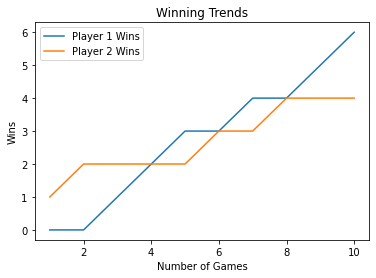

In [50]:
# Initialize lists to store the wins for each player
player1_wins_list = []
player2_wins_list = []

# Define the number of games to play
num_games = 10

# Play multiple games and collect the results
for _ in range(num_games):
    # Create a new instance of the game
    lose_vs_random = Game(TryToLoseStrategy(), RandomStrategy())
    # Play the game
    lose_vs_random.play()
    # Check the winner of each game and update the win lists
    if lose_vs_random.player1.score > lose_vs_random.player2.score:
        player1_wins_list.append(1)
        player2_wins_list.append(0)
    elif lose_vs_random.player2.score > lose_vs_random.player1.score:
        player1_wins_list.append(0)
        player2_wins_list.append(1)
    else:
        player1_wins_list.append(0)
        player2_wins_list.append(0)

# Calculate cumulative wins for each player
cumulative_wins_player1 = [sum(player1_wins_list[:i+1]) for i in range(num_games)]
cumulative_wins_player2 = [sum(player2_wins_list[:i+1]) for i in range(num_games)]

# Plot the winning trends
plot_winning_trends(cumulative_wins_player1, cumulative_wins_player2)


Player 1 choice: Paper, Player 2 choice: Lizard
Outcome: ('Paper', 'Lizard')
Scores -> Player 1: -2, Player 2: 4
Player 1 choice: Spock, Player 2 choice: Spock
Outcome: ('Spock', 'Spock')
Scores -> Player 1: -2, Player 2: 4
Player 1 choice: Scissors, Player 2 choice: Spock
Outcome: ('Scissors', 'Spock')
Scores -> Player 1: -5, Player 2: 9
Player 1 choice: Scissors, Player 2 choice: Lizard
Outcome: ('Scissors', 'Lizard')
Scores -> Player 1: -2, Player 2: 5
Player 1 choice: Scissors, Player 2 choice: Lizard
Outcome: ('Scissors', 'Lizard')
Scores -> Player 1: 1, Player 2: 1
Player 1 choice: Spock, Player 2 choice: Lizard
Outcome: ('Spock', 'Lizard')
Scores -> Player 1: -4, Player 2: 5
Player 1 choice: Lizard, Player 2 choice: Lizard
Outcome: ('Lizard', 'Lizard')
Scores -> Player 1: -4, Player 2: 5
Player 1 choice: Rock, Player 2 choice: Spock
Outcome: ('Rock', 'Spock')
Scores -> Player 1: -5, Player 2: 10
Player 1 choice: Rock, Player 2 choice: Lizard
Outcome: ('Rock', 'Lizard')
Scores ->

Player 1 choice: Paper, Player 2 choice: Lizard
Outcome: ('Paper', 'Lizard')
Scores -> Player 1: -1, Player 2: 4
Player 1 choice: Lizard, Player 2 choice: Spock
Outcome: ('Lizard', 'Spock')
Scores -> Player 1: 3, Player 2: -1
Player 1 choice: Paper, Player 2 choice: Lizard
Outcome: ('Paper', 'Lizard')
Scores -> Player 1: 1, Player 2: 3
Player 1 choice: Lizard, Player 2 choice: Spock
Outcome: ('Lizard', 'Spock')
Scores -> Player 1: 5, Player 2: -2
Player 1 choice: Lizard, Player 2 choice: Lizard
Outcome: ('Lizard', 'Lizard')
Scores -> Player 1: 5, Player 2: -2
Player 1 choice: Spock, Player 2 choice: Spock
Outcome: ('Spock', 'Spock')
Scores -> Player 1: 5, Player 2: -2
Player 1 choice: Lizard, Player 2 choice: Spock
Outcome: ('Lizard', 'Spock')
Scores -> Player 1: 9, Player 2: -7
Player 1 choice: Rock, Player 2 choice: Spock
Outcome: ('Rock', 'Spock')
Scores -> Player 1: 8, Player 2: -2
Player 1 choice: Rock, Player 2 choice: Spock
Outcome: ('Rock', 'Spock')
Scores -> Player 1: 7, Playe

Outcome: ('Rock', 'Spock')
Scores -> Player 1: 7, Player 2: 1
Player 1 choice: Scissors, Player 2 choice: Lizard
Outcome: ('Scissors', 'Lizard')
Scores -> Player 1: 10, Player 2: -3
Player 1 choice: Lizard, Player 2 choice: Lizard
Outcome: ('Lizard', 'Lizard')
Scores -> Player 1: 10, Player 2: -3
Player 1 choice: Spock, Player 2 choice: Lizard
Outcome: ('Spock', 'Lizard')
Scores -> Player 1: 5, Player 2: 1
Player 1 choice: Paper, Player 2 choice: Lizard
Outcome: ('Paper', 'Lizard')
Scores -> Player 1: 3, Player 2: 5
Player 1 choice: Scissors, Player 2 choice: Lizard
Outcome: ('Scissors', 'Lizard')
Scores -> Player 1: 6, Player 2: 1
Player 1 choice: Spock, Player 2 choice: Lizard
Outcome: ('Spock', 'Lizard')
Scores -> Player 1: 1, Player 2: 5
Player 1 choice: Paper, Player 2 choice: Spock
Outcome: ('Paper', 'Spock')
Scores -> Player 1: 3, Player 2: 0
Player 1 choice: Scissors, Player 2 choice: Spock
Outcome: ('Scissors', 'Spock')
Scores -> Player 1: 0, Player 2: 5
Player 1 choice: Spock

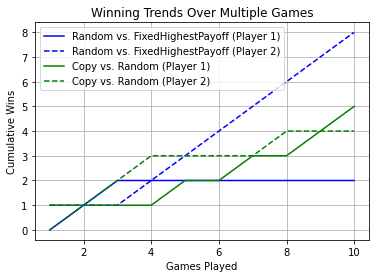

In [52]:
import matplotlib.pyplot as plt

# Function to plot winning trends
def plot_winning_trends(player1_wins, player2_wins):
    # Create a list of colors for each scenario
    colors = ['b', 'g', 'r']
    # Plot the winning trends for Player 1 and Player 2 for each scenario
    for i, (scenario, wins) in enumerate(player1_wins.items()):
        plt.plot(range(1, len(wins) + 1), wins, label=f'{scenario} (Player 1)', color=colors[i])
        plt.plot(range(1, len(player2_wins[scenario]) + 1), player2_wins[scenario], label=f'{scenario} (Player 2)', linestyle='dashed', color=colors[i])

    # Add labels and legend
    plt.xlabel('Games Played')
    plt.ylabel('Cumulative Wins')
    plt.title('Winning Trends Over Multiple Games')
    plt.legend()
    plt.grid(True)
    # Show the plot
    plt.show()

# Initialize lists to store the wins for each player for each scenario
player1_wins_lists = {
    "Random vs. FixedHighestPayoff": [],
    "Copy vs. Random": []
}
player2_wins_lists = {
    "Random vs. FixedHighestPayoff": [],
    "Copy vs. Random": []
}

# Define the number of games to play
num_games = 10

# Play each scenario for multiple games and collect the results
for _ in range(num_games):
    # Random vs. FixedHighestPayoff
    random_vs_fixed = Game(RandomStrategy(), FixedHighestPayoffStrategy())
    random_vs_fixed.play()
    if random_vs_fixed.player1.score > random_vs_fixed.player2.score:
        player1_wins_lists["Random vs. FixedHighestPayoff"].append(1)
        player2_wins_lists["Random vs. FixedHighestPayoff"].append(0)
    elif random_vs_fixed.player2.score > random_vs_fixed.player1.score:
        player1_wins_lists["Random vs. FixedHighestPayoff"].append(0)
        player2_wins_lists["Random vs. FixedHighestPayoff"].append(1)
    else:
        player1_wins_lists["Random vs. FixedHighestPayoff"].append(0)
        player2_wins_lists["Random vs. FixedHighestPayoff"].append(0)

    # Copy vs. Random
    copy_vs_random_game = Game(CopyStrategy(), RandomStrategy())
    copy_vs_random_game.play()
    if copy_vs_random_game.player1.score > copy_vs_random_game.player2.score:
        player1_wins_lists["Copy vs. Random"].append(1)
        player2_wins_lists["Copy vs. Random"].append(0)
    elif copy_vs_random_game.player2.score > copy_vs_random_game.player1.score:
        player1_wins_lists["Copy vs. Random"].append(0)
        player2_wins_lists["Copy vs. Random"].append(1)
    else:
        player1_wins_lists["Copy vs. Random"].append(0)
        player2_wins_lists["Copy vs. Random"].append(0)

# Calculate cumulative wins for each scenario
cumulative_wins_player1 = {}
cumulative_wins_player2 = {}
for scenario, wins_list in player1_wins_lists.items():
    cumulative_wins_player1[scenario] = [sum(wins_list[:i+1]) for i in range(num_games)]
for scenario, wins_list in player2_wins_lists.items():
    cumulative_wins_player2[scenario] = [sum(wins_list[:i+1]) for i in range(num_games)]

# Plot the winning trends for each scenario
plot_winning_trends(cumulative_wins_player1, cumulative_wins_player2)
